In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from caveclient import CAVEclient
import seaborn as sea
from itertools import compress

import sys
sys.path.append('utils')
from FANC_utils import filter_syn_df, compute_connectivity_matrix, hl_nt_dict, sort_partial_match

In [2]:
# Initialize CAVEclient
# This step requires an authentication token, see https://caveclient.readthedocs.io/en/latest/guide/authentication.html
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.version = 840

In [3]:
# Load table 

# Select claw and hook neurons
cell_type = ['claw_flx','claw_ext','hook_flx','hook_ext']

df = client.materialize.query_table('feco_axons_v0', 
                                    filter_in_dict = {'cell_type': cell_type})

# Exclude partially reconstructed claw axons
pt_position_to_exclude = np.array([[9093, 101264, 3740], [9401, 100947, 3740]])
ix_to_exclude = []
for ix, i in df.iterrows():
    if (df.pt_position[ix]==pt_position_to_exclude).all(axis=1).any():
        ix_to_exclude.append(ix)
df = df.drop(ix_to_exclude)

In [4]:
# Get IDs of FeCO neurons
feco_ids = df.pt_root_id.tolist()

In [5]:
# Query input synapses 
syn_df = client.materialize.synapse_query(post_ids = feco_ids)

In [6]:
# Remove connections less than syn_thresh from syn_df
syn_thresh = 3
syn_df = filter_syn_df(syn_df, syn_thresh)

In [7]:
# Compute connectivity matrix 
conn_mat, pre_ids, post_ids = compute_connectivity_matrix(syn_df)

In [8]:
# Get FeCO IDs and partner IDs 
feco_ids = post_ids
partner_ids = pre_ids

In [9]:
# Get FeCO names     
feco_names = []
for i in feco_ids:
    cell_type = df.cell_type[df.pt_root_id==i].tolist()
    feco_id = df.id[df.pt_root_id==i].tolist()
    name = ''.join(cell_type + ['_'] + [str(x) for x in feco_id])
    feco_names.append(name)

In [10]:
# Get partner names
partner_df = client.materialize.query_table('upstream_feco_axons') 
partner_names = []
for i in partner_ids:
    if i in partner_df.pt_root_id.to_list():
        name_type = str(partner_df.cell_type[partner_df.pt_root_id==i].item())
        name = name_type + '_' + str(i) 
    else:
        name = 'unknown_' + str(i)
    partner_names.append(name)

In [11]:
partner_df_ids = partner_df.pt_root_id.unique().tolist()

In [12]:
# Sort columns of connectivity matrix based on FeCO subtype   
sort_list = ['claw_flx','claw_ext','hook_flx','hook_ext']
feco_names_sorted = sort_partial_match(feco_names, sort_list)
sort_idx = [feco_names.index(i) for i in feco_names_sorted]

conn_mat_sorted = conn_mat[:,sort_idx]
feco_names_sorted = [feco_names[i] for i in sort_idx]
feco_ids_sorted = [feco_ids[i] for i in sort_idx]

# Sort rows of connectiviity matrix based on FeCO subtype targeted, primary neurotransmitter, and hemilineage
nt_dict = hl_nt_dict()
nt_dict['hook'] = 'ACh'
nt_dict['club'] = 'ACh'
nt_dict['hair_plate'] = 'ACh'
nt_dict['unknown'] = 'unknown'

hl_list = list(nt_dict.keys())

idx_list = []
for ix, i in enumerate(partner_ids):       
        # Get target index
        claw_idx = [ix for ix, i in enumerate(feco_names_sorted) if "claw" in i]
        trans_idx = claw_idx[-1]
        neurons_targeted = list(np.where(conn_mat_sorted[ix,:]>0)[0])
        if max(neurons_targeted) <= trans_idx:
            target_idx = 0 # Claw
        elif min(neurons_targeted) > trans_idx:
            target_idx = 1 # Hook
        else:
            target_idx = 2 # Claw and hook 

        # Get neurotransmitter index
        if i in partner_df_ids:
            cell_type = partner_df.cell_type[partner_df.pt_root_id == i].item()
            # Look up primary neurotransmitter  
            nt = nt_dict[cell_type]
        else: 
            cell_type = 'unknown'
            nt = 'unknown'

        if nt == 'GABA':
            nt_idx = 0
        elif nt == 'Glu':
            nt_idx = 1
        elif nt == 'ACh':
            nt_idx = 2
        else:
            nt_idx = 3

        # Get hemilineage index
        hl_idx = hl_list.index(cell_type)
        
        idx_list.append([ix,target_idx,nt_idx,hl_idx])

# Sort idx_list based on attributes target_idx, nt_idx, and hl_idx in descending order
idx_list_sorted = sorted(idx_list, key = lambda x: (x[1], x[2], x[3])) #, reverse = True)

# Get sort idx (first element of each list)
sort_idx = [i[0] for i in idx_list_sorted]

# Sort columns of conn_mat and partner IDs
conn_mat_sorted = conn_mat_sorted[sort_idx,:]
partner_names_sorted = [partner_names[i] for i in sort_idx]
partner_ids_sorted = [partner_ids[i] for i in sort_idx]

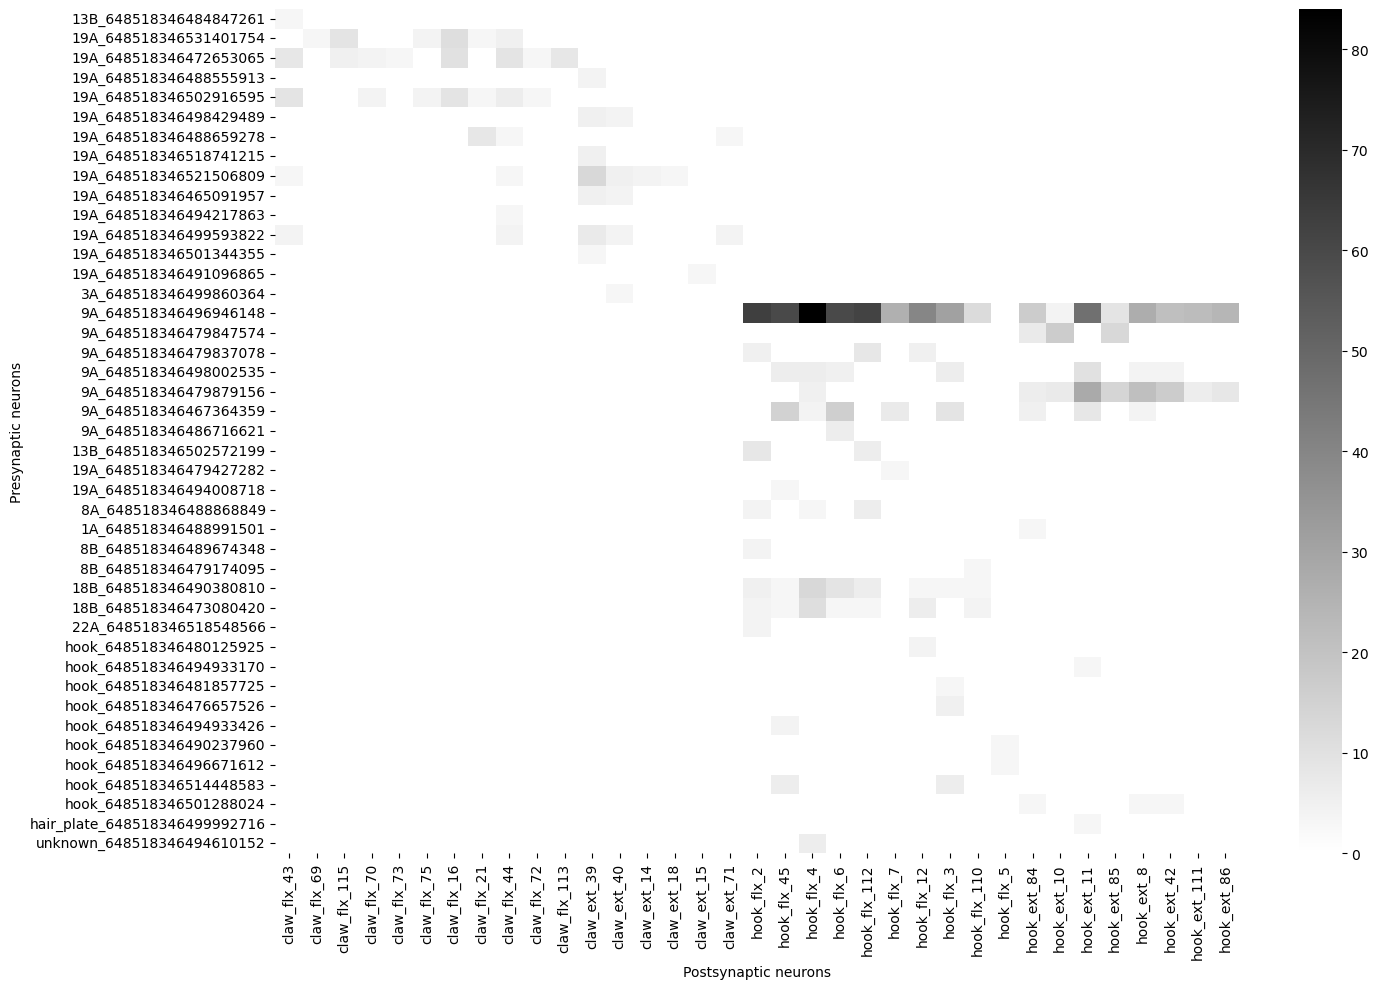

In [13]:
# Plot connectivity matrix
fig = plt.figure(figsize=(15,10))
cmap = sea.color_palette("gray_r", as_cmap=True)
xticklabels = feco_names_sorted
yticklabels = partner_names_sorted
sea.heatmap(conn_mat_sorted, 
            cmap=cmap,
            xticklabels=xticklabels, 
            yticklabels=yticklabels)            
plt.xlabel('Postsynaptic neurons')
plt.ylabel('Presynaptic neurons')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

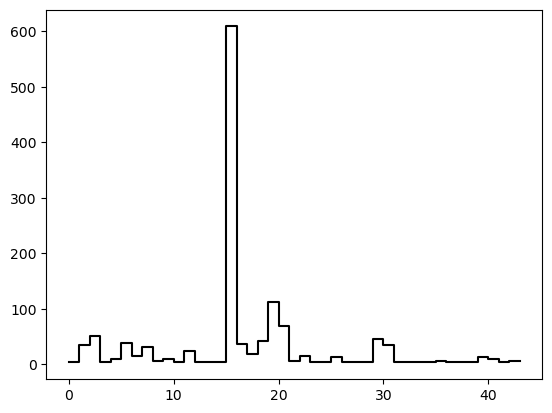

In [79]:
# Plot distribution of synapses
# For columns, set axis=0
# For rows, set axis=1
n_syn = np.sum(conn_mat_sorted,axis=1)
plt.step(range(len(n_syn)+1), np.insert(n_syn, 0, n_syn[0]), color=[0,0,0]) # For step function, duplicate first value
plt.show()

# Calculate hook input from 9A

In [69]:
yticklabels[26:42] # 15:22

['1A_648518346488991501',
 '8B_648518346489674348',
 '8B_648518346479174095',
 '18B_648518346490380810',
 '18B_648518346473080420',
 '22A_648518346518548566',
 'hook_648518346480125925',
 'hook_648518346494933170',
 'hook_648518346481857725',
 'hook_648518346476657526',
 'hook_648518346494933426',
 'hook_648518346490237960',
 'hook_648518346496671612',
 'hook_648518346514448583',
 'hook_648518346501288024',
 'hair_plate_648518346499992716']

In [58]:
xticklabels[17:] # 17:

['hook_flx_2',
 'hook_flx_45',
 'hook_flx_4',
 'hook_flx_6',
 'hook_flx_112',
 'hook_flx_7',
 'hook_flx_12',
 'hook_flx_3',
 'hook_flx_110',
 'hook_flx_5',
 'hook_ext_84',
 'hook_ext_10',
 'hook_ext_11',
 'hook_ext_85',
 'hook_ext_8',
 'hook_ext_42',
 'hook_ext_111',
 'hook_ext_86']

In [62]:
n_syn_hook_all = np.sum(np.sum(conn_mat_sorted[:,17:],axis=0))
n_syn_hook_all

1072.0

In [72]:
n_syn_hook_9A = np.sum(np.sum(conn_mat_sorted[26:42,17:],axis=1))
n_syn_hook_9A

142.0

In [73]:
n_syn_hook_9A/n_syn_hook_all

0.13246268656716417

In [87]:
n_syn_9A = np.sum(conn_mat_sorted[15:22],axis=1)
n_syn_9A

array([609.,  37.,  18.,  41., 112.,  68.,   6.])

In [88]:
n_syn_9A_rel = n_syn_9A/n_syn_all_hook
n_syn_9A_rel

array([0.56809701, 0.03451493, 0.01679104, 0.03824627, 0.10447761,
       0.06343284, 0.00559701])